In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score  # Use appropriate metrics for your task


Dataset

In [3]:
data = {}
import json
with open('nvdcve-1.1-2023.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

#print(data)

In [4]:
def severity2score(str):
    if str == 'NONE'or str == 'LOCAL' or str == 'UNCHANGED' or str == '':
        return 0
    elif str == 'LOW' or str == 'REQUIRED' or str == 'CHANGED' or str == 'NETWORK':
        return 1
    elif str == 'MEDIUM' or str == 'ADJACENT_NETWORK':
        return 2
    elif str == 'HIGH' or str == 'PHYSICAL' :
        return 3
    elif str == 'CRITICAL':
        return 4
    else:
        print(str)

cve_items = data.get("CVE_Items", [])

# Create an empty list to store dictionaries representing entries
entries = []

# Extract and append the dictionaries representing entries
for item in cve_items:
    entry = {
        #"ID": item['cve']['CVE_data_meta']['ID'],
        #"Problem Type": item['cve']['problemtype']['problemtype_data'][0]['description'],
        #"CVSS Version": item['impact']['baseMetricV3']['cvssV3']['version'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "",
        #"CVSS Vector": item['impact']['baseMetricV3']['cvssV3']['vectorString'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "",
        "CVSS Base Score": float(item['impact']['baseMetricV3']['cvssV3']['baseScore'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "0"),
        "CVSS Severity":  severity2score(item['impact']['baseMetricV3']['cvssV3']['baseSeverity'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        #"Description": item['cve']['description']['description_data'][0]['value'],
        #"Config": item['configurations'],
        #"Reference": item['cve']['references'],
        "Attack Complexity": severity2score(item['impact']['baseMetricV3']['cvssV3']['attackComplexity'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Privileges Required": severity2score(item['impact']['baseMetricV3']['cvssV3']['privilegesRequired'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "User Interaction": severity2score(item['impact']['baseMetricV3']['cvssV3']['userInteraction'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Confidentiality Impact": severity2score(item['impact']['baseMetricV3']['cvssV3']['confidentialityImpact'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Integrity Impact": severity2score(item['impact']['baseMetricV3']['cvssV3']['integrityImpact'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Availability Impact": severity2score(item['impact']['baseMetricV3']['cvssV3']['availabilityImpact'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Attack Vector": severity2score(item['impact']['baseMetricV3']['cvssV3']['attackVector'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Scope": severity2score(item['impact']['baseMetricV3']['cvssV3']['scope'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Exploitability Score": float(item['impact']['baseMetricV3']['exploitabilityScore'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "0"),
        "Impact Score": float(item['impact']['baseMetricV3']['impactScore'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "0"),
        
    }
    entries.append(entry)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(entries)

# Calculate the shape of the DataFrame
num_entries, num_features = df.shape
# Save the DataFrame as a CSV file
df.to_csv("cve_data.csv", index=False)

print("CSV file 'cve_data.csv' saved successfully.")
df.shape

CSV file 'cve_data.csv' saved successfully.


(14881, 12)

In [5]:
df.head()


,CVSS Base Score,CVSS Severity,Attack Complexity,Privileges Required,User Interaction,Confidentiality Impact,Integrity Impact,Availability Impact,Attack Vector,Scope,Exploitability Score,Impact Score
0,6.7,2,1,3,0,3,3,3,0,0,0.8,5.9
1,7.8,3,1,1,0,3,3,3,0,0,1.8,5.9
2,6.5,2,1,1,0,3,0,0,1,0,2.8,3.6
3,6.5,2,1,3,0,0,3,3,1,0,1.2,5.2
4,4.9,2,1,3,0,3,0,0,1,0,1.2,3.6


In [6]:
X = df
y = df["Impact Score"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train shape:", X_test.shape)
print("y_train shape:", y_test.shape)

print("X_test:", X_test)
print("y_test:", y_test)

X_train shape: (11904, 12)
y_train shape: (11904,)
X_train shape: (2977, 12)
y_train shape: (2977,)
X_test:        CVSS Base Score  CVSS Severity  Attack Complexity  Privileges Required  \
10346              7.8              3                  1                    1   
5075               7.5              3                  1                    0   
4100               9.8              4                  1                    0   
8613               6.5              2                  1                    0   
6985               7.8              3                  1                    0   
...                ...            ...                ...                  ...   
9274               5.5              2                  1                    1   
6857               7.2              3                  1                    3   
2964               5.5              2                  1                    0   
8287               7.5              3                  1                    0   
1

In [8]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error')


In [14]:
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1)#, callbacks=[early_stopping])

Epoch 1/150
372/372 [==============================] - 0s 822us/step - loss: 3.9667e-05
Epoch 2/150
372/372 [==============================] - 0s 794us/step - loss: 2.3629e-04
Epoch 3/150
372/372 [==============================] - 0s 850us/step - loss: 1.4008e-05
Epoch 4/150
372/372 [==============================] - 0s 834us/step - loss: 1.8650e-05
Epoch 5/150
372/372 [==============================] - 0s 806us/step - loss: 5.8991e-05
Epoch 6/150
372/372 [==============================] - 0s 797us/step - loss: 6.7660e-05
Epoch 7/150
372/372 [==============================] - 0s 810us/step - loss: 3.6744e-05
Epoch 8/150
372/372 [==============================] - 0s 805us/step - loss: 5.1033e-05
Epoch 9/150
372/372 [==============================] - 0s 798us/step - loss: 7.4075e-05
Epoch 10/150
372/372 [==============================] - 0s 788us/step - loss: 5.0269e-05
Epoch 11/150
372/372 [==============================] - 0s 790us/step - loss: 2.9903e-05
Epoch 12/150
372/372 [========

94/94 [==============================] - 0s 713us/step
Mean Squared Error on Test Data (MSE): 1.1973301996949766e-05
Root Mean Squared Error (RMSE): 0.0034602459445752937
Mean Absolute Error (MAE): 0.0026621844070165005
R-squared (R2) Score: 0.9999957617979658


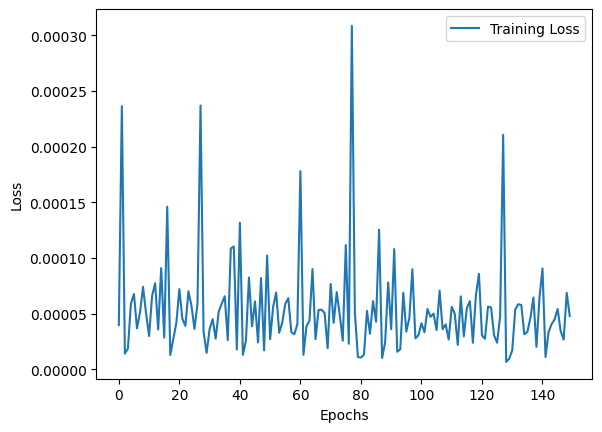

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the model on the test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error on Test Data (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Score: {r2}")


# Optionally, you can visualize the training history to see the loss curve
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()